In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from dotenv import load_dotenv

In [2]:
load_dotenv()

api_key = os.getenv("ALPHA_VANTAGE_API_KEY")

ticker = "AAL"

url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

file_to_save = 'stock_market_data-%s.csv'%ticker

if not os.path.exists(file_to_save):
    with urllib.request.urlopen(url_string) as url:
        data = json.loads(url.read().decode())
        # extract stock market data
        data = data['Time Series (Daily)']
        df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
        for k,v in data.items():
            date = dt.datetime.strptime(k, '%Y-%m-%d')
            data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                        float(v['4. close']),float(v['1. open'])]
            df.loc[-1,:] = data_row
            df.index = df.index + 1
    print('Data saved to : %s'%file_to_save)        
    df.to_csv(file_to_save)

# If the data is already there, just load it from the CSV
else:
    print('File already exists. Loading data from CSV')
    df = pd.read_csv(file_to_save)

File already exists. Loading data from CSV


In [9]:
df = df.sort_values('Date')
df.head()
len(df)

4991

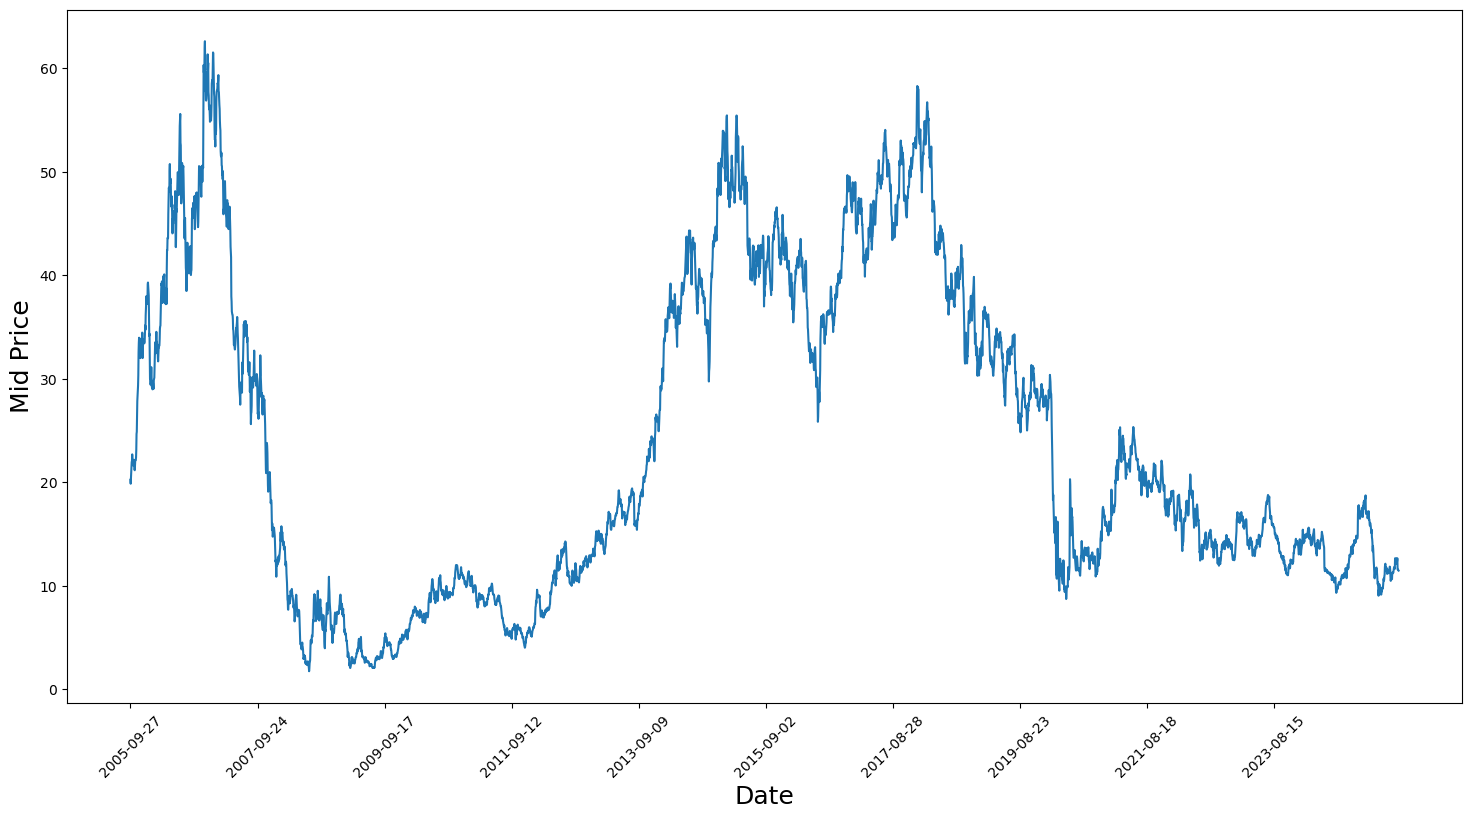

In [10]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [11]:
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = ((high_prices+low_prices)/2)

In [12]:
train_data = mid_prices[:4000]
test_data = mid_prices[4000:]

In [13]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [14]:
smoothing_window = 1000
n_samples = train_data.shape[0]

for di in range(0,n_samples - smoothing_window,smoothing_window):
    scaler.fit(train_data[di:di+smoothing_window, :])
    train_data[di:di+smoothing_window, :] = scaler.transform(train_data[di:di+smoothing_window, :])

scaler.fit(train_data[di+smoothing_window:, :])
train_data[di+smoothing_window:, :] = scaler.transform(train_data[di+smoothing_window:, :])

In [16]:
train_data = train_data.reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

In [ ]:
#Data smoothing using Exponential Moving Average
EMA = 0.0
gamma = 0.1
for ti in range(4000):
  EMA = gamma * train_data[ti] + (1 - gamma) * EMA
  train_data[ti] = EMA

all_mid_data = np.concatenate((train_data,test_data),axis=0)

**One Step Ahead Prediction via Averaging**

Standard Average

In [19]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00646


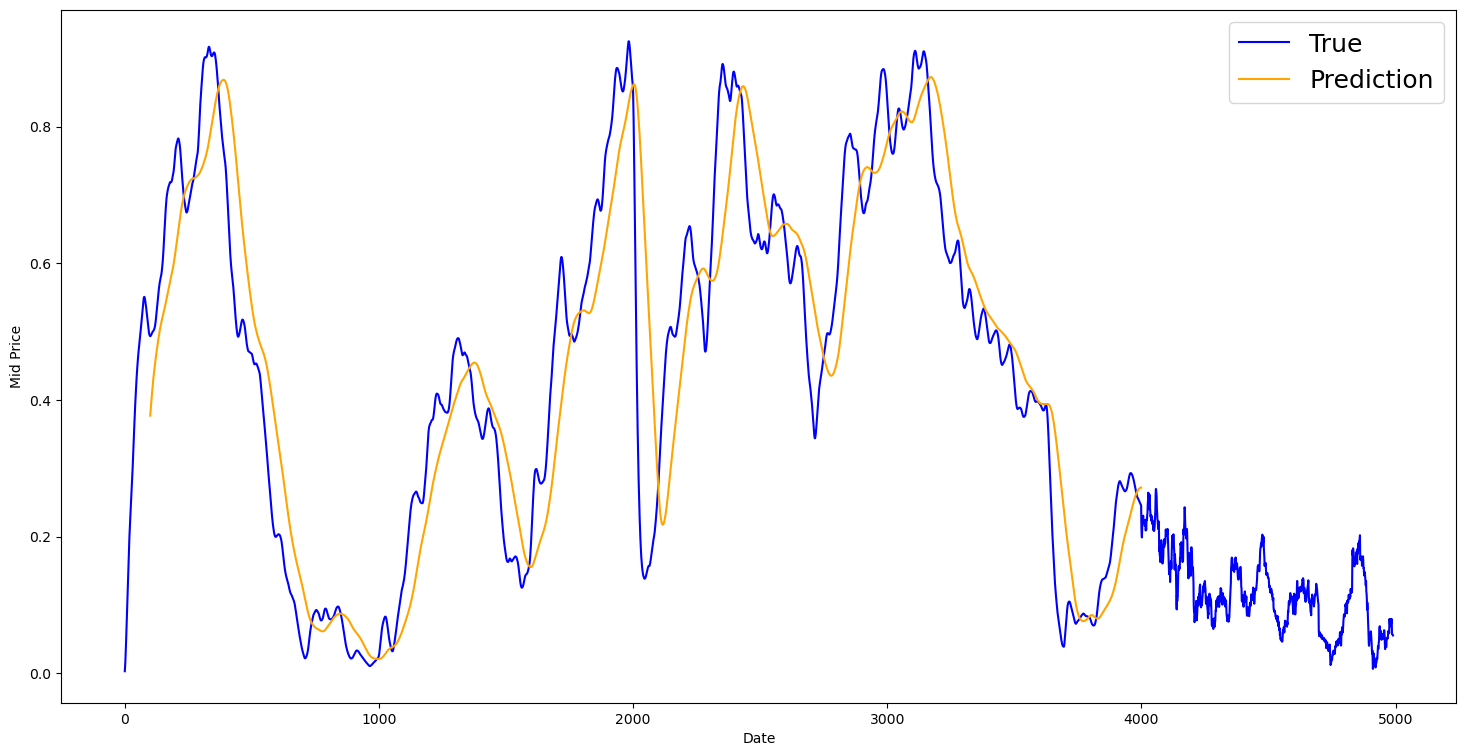

In [20]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Exponential Moving Average

In [21]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []
mse_errors = []

run_mean = 0.0
run_avg_predictions.append(run_mean)

decay = 0.5

for pred_idx in range(1,N):
  run_mean = run_mean * decay + (1 - decay) * train_data[pred_idx-1]
  run_avg_predictions.append(run_mean)
  mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
  run_avg_x.append(date)

print('MSE error for running average: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for running average: 0.00003


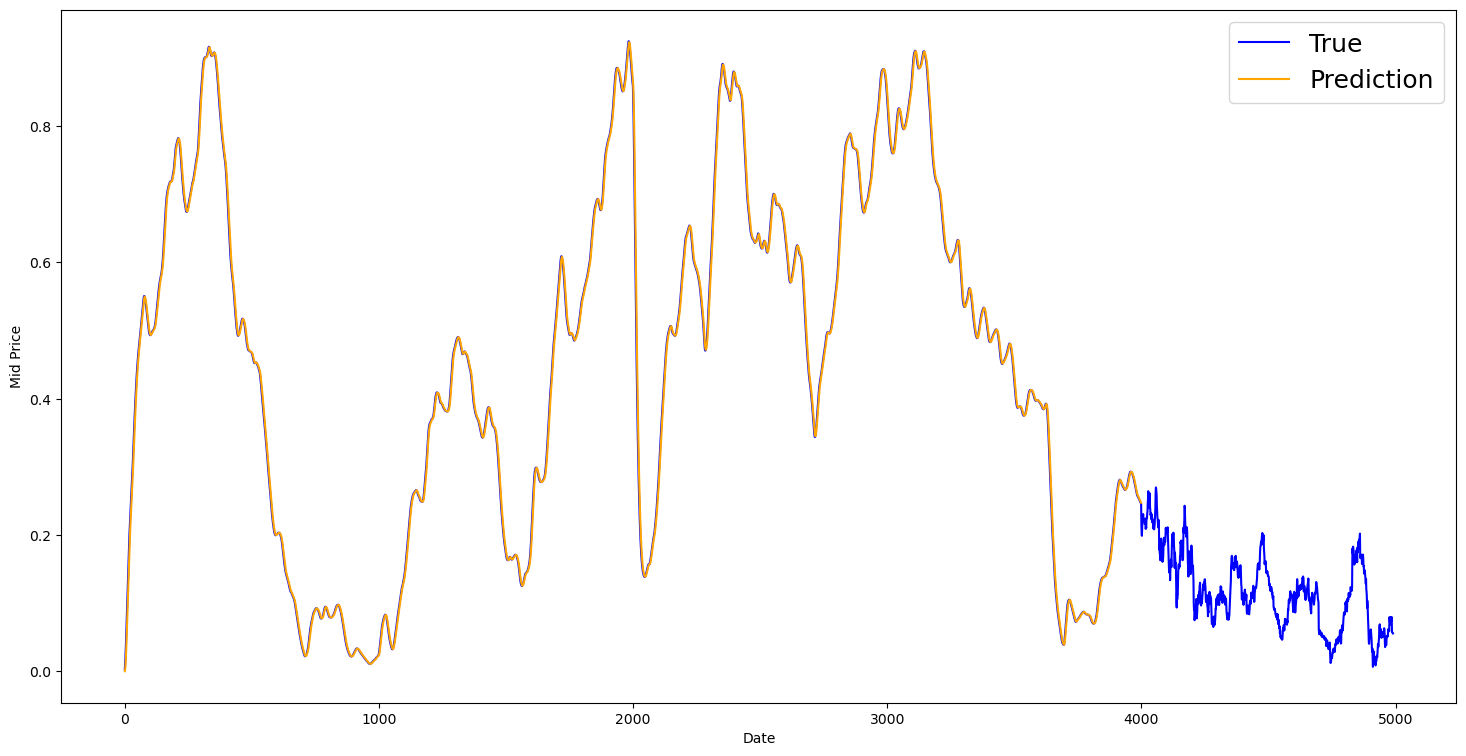

In [22]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

**Prediction using an LSTM**

In [23]:
class DataGeneratorSeq(object):
  def __init__(self, prices, batch_size, num_unroll):
    self._prices = prices
    self._prices_len = len(self._prices) - num_unroll
    self._batch_size = batch_size
    self._num_unroll = num_unroll
    self._segments = self._prices_len // self._batch_size
    self._cursor = [offset * self._segments for offset in range(self._batch_size)]

  def next_batch(self):

    batch_data = np.zeros((self._batch_size), dtype=np.float32)
    batch_labels = np.zeros((self._batch_size),dtype=np.float32)

    for b in range(self._batch_size):
      if self._cursor[b] + 1 >= self._prices_len:
        self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
      
      batch_data[b] = self._prices[self._cursor[b]]
      batch_labels[b] = self._prices[self._cursor[b] + np.random.randint(0,5)]
      self._cursor[b] = (self._cursor[b] + 1) % self._prices_len
    
    return batch_data, batch_labels
  
  def unroll_batches(self):

    unroll_data,unroll_labels = [],[]
    init_data, init_labels = None, None

    for ui in range(self._num_unroll):
      data, labels = self.next_batch()
      unroll_data.append(data)
      unroll_labels.append(labels)
    
    return unroll_data, unroll_labels
  
  def reset(self):
    for b in range(self._batch_size):
      self._cursor[b] = np.random.randint(0,min(b+1)*self._segments, self._prices_len-1)

dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
  print('\n\nUnrolled index %d'%ui)
  dat_ind = dat
  lbl_ind = lbl
  print('\tInputs: ',dat )
  print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.00303966 0.0856012  0.18811122 0.8798966  0.71582323]

	Output: [0.00303966 0.08175903 0.2109876  0.87895113 0.71511453]


Unrolled index 1
	Inputs:  [0.00844782 0.08427507 0.19508804 0.87895113 0.71511453]

	Output: [0.00844782 0.08427507 0.19508804 0.87751377 0.71511453]


Unrolled index 2
	Inputs:  [0.01579839 0.08296822 0.2028454  0.87751377 0.71444285]

	Output: [0.05803875 0.08175903 0.22744794 0.87065476 0.7137202 ]


Unrolled index 3
	Inputs:  [0.02469397 0.08175903 0.2109876  0.87563366 0.7137202 ]

	Output: [0.05803875 0.08175903 0.23542127 0.87065476 0.712035  ]


Unrolled index 4
	Inputs:  [0.03486864 0.08076501 0.21925095 0.87323093 0.7129403 ]

	Output: [0.07058407 0.08003077 0.21925095 0.8679991  0.7081096 ]


In [1]:
D = 1 # Dimensionality of the data.
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount